In [1]:
import pandas as pd
import multiprocessing as mp 
import matplotlib.pyplot as plt
import dask.dataframe as dd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np



In [2]:
# thigs that didnt work,  multiprocessing, dask, for large data files.  

In [3]:
df_2022 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2022.pkl')
df_2023 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2023.pkl')
# df_2024 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2024.pkl')

In [4]:
# Merger the dataframes
ridership_data_all_years = pd.concat([df_2022, df_2023], axis=0)

In [5]:
# hourly_ridership_data = df_2022.copy()
hourly_ridership_data = ridership_data_all_years.copy()


In [6]:
hourly_ridership_data['transit_timestamp'] = pd.to_datetime(hourly_ridership_data['transit_timestamp'])

In [7]:
# create a df for each month 
jan = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 1]
feb = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 2]
mar = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 3]
apr = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 4]
may = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 5]
jun = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 6]
jul = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 7]
aug = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 8]
sep = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 9]
oct = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 10]
nov = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 11]
dec = hourly_ridership_data[hourly_ridership_data['transit_timestamp'].dt.month == 12]


In [8]:
feb.shape
print(feb.sample(5))

           transit_timestamp transit_mode station_complex_id  \
11807086 2022-02-12 07:00:00       subway                385   
14733258 2022-02-07 15:00:00       subway                183   
8214622  2022-02-23 18:00:00       subway                 17   
12446525 2023-02-14 07:00:00       subway                213   
7391014  2022-02-18 22:00:00       subway                260   

           station_complex    borough payment_method    fare_class_category  \
11807086        176 St (4)      Bronx      metrocard   Metrocard - Students   
14733258   Rockaway Av (C)   Brooklyn      metrocard      Metrocard - Other   
8214622    Prince St (R,W)  Manhattan      metrocard   Metrocard - Students   
12446525  Fordham Rd (B,D)      Bronx      metrocard  Metrocard - Full Fare   
7391014        75 Av (E,F)     Queens           omny       OMNY - Full Fare   

         ridership transfers   latitude  longitude  \
11807086         2         0  40.848480 -73.911800   
14733258         6         0  40

In [9]:
months_data = {
    'January': jan,
    'February': feb,
    'March': mar,
    'April': apr,
    'May': may,
    'June': jun,
    'July': jul,
    'August': aug,
    'September': sep,
    'October': oct,
    'November': nov,
    'December': dec
}



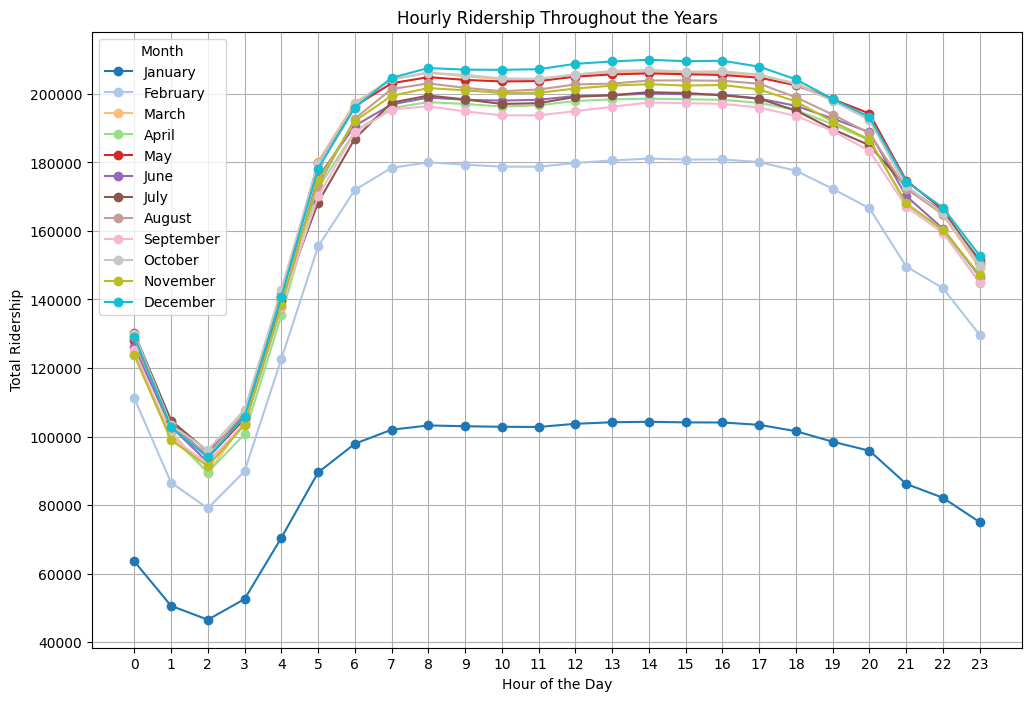

In [10]:
colormap = plt.colormaps['tab20']
colors = [colormap(i / 12) for i in range(12)]

plt.figure(figsize=(12, 8))
for i, (month_name, month_data) in enumerate(months_data.items()):
    hourly_ridership = month_data.groupby(month_data['transit_timestamp'].dt.hour).size().reset_index(name='ridership')
    hourly_ridership.rename(columns={'transit_timestamp': 'hour'}, inplace=True)
    plt.plot(hourly_ridership['hour'], hourly_ridership['ridership'], marker='o', color=colors[i], label=month_name)
plt.title("Hourly Ridership Throughout the Years")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Ridership")
plt.grid(True)
plt.xticks(range(0, 24))

plt.legend(title="Month")
plt.show()


In [11]:
# Assume the DataFrame `hourly_ridership_data` is loaded with 'transit_timestamp' and 'ridership'
# Remove commas from 'ridership' and convert to float
hourly_ridership_data['ridership'] = hourly_ridership_data['ridership'].replace({',': ''}, regex=True).astype(float)
# ensure timeformat
hourly_ridership_data['transit_timestamp'] = pd.to_datetime(hourly_ridership_data['transit_timestamp'])

# exttract time-based features
hourly_ridership_data['hour'] = hourly_ridership_data['transit_timestamp'].dt.hour
hourly_ridership_data['day_of_week'] = hourly_ridership_data['transit_timestamp'].dt.dayofweek

In [12]:
import numpy as np

In [13]:
# Cyclical encoding for hour and day of the week
# REFERENCE:  https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
hourly_ridership_data['hour_sin'] = np.sin(2 * np.pi * hourly_ridership_data['hour'] / 24)
hourly_ridership_data['hour_cos'] = np.cos(2 * np.pi * hourly_ridership_data['hour'] / 24)
hourly_ridership_data['day_of_week_sin'] = np.sin(2 * np.pi * hourly_ridership_data['day_of_week'] / 7)
hourly_ridership_data['day_of_week_cos'] = np.cos(2 * np.pi * hourly_ridership_data['day_of_week'] / 7)

hourly_ridership_data['ridership_lag_1'] = hourly_ridership_data['ridership'].shift(1)
hourly_ridership_data['ridership_lag_24'] = hourly_ridership_data['ridership'].shift(24)

hourly_ridership_data.dropna(inplace=True)

In [14]:
# Define features and target
X = hourly_ridership_data[['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'ridership_lag_1', 'ridership_lag_24']].values
y = hourly_ridership_data['ridership'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = RandomForestRegressor(n_estimators=100, random_state=42,  n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [17]:
y_pred = model.predict(X_test)

In [18]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 139.54698458430153


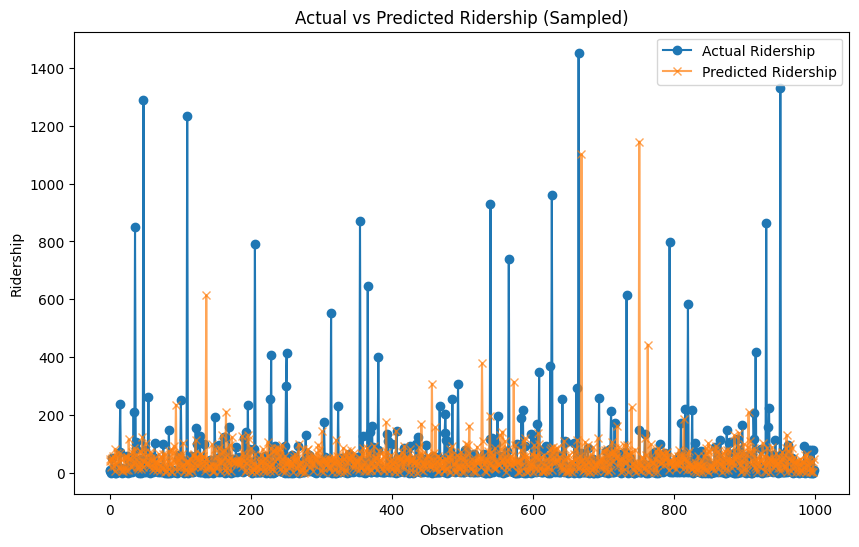

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:1000], label='Actual Ridership', marker='o')  # No .values needed
plt.plot(y_pred[:1000], label='Predicted Ridership', alpha=0.7, marker='x')
plt.legend()
plt.title("Actual vs Predicted Ridership (Sampled)")
plt.xlabel("Observation")
plt.ylabel("Ridership")
plt.show()


In [22]:
# Define the specific date and time to check predicted ridership
target_datetime = pd.to_datetime("2022-03-04 13:00:00")

# Extract cyclical features
hour = target_datetime.hour
day_of_week = target_datetime.dayofweek

# Calculate cyclical features
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)
day_of_week_sin = np.sin(2 * np.pi * day_of_week / 7)
day_of_week_cos = np.cos(2 * np.pi * day_of_week / 7)

# Handle missing lag data by checking if values exist
lag_1_data = hourly_ridership_data.loc[hourly_ridership_data['transit_timestamp'] == target_datetime - pd.Timedelta(hours=1), 'ridership']
lag_24_data = hourly_ridership_data.loc[hourly_ridership_data['transit_timestamp'] == target_datetime - pd.Timedelta(hours=24), 'ridership']

# Use actual values if available, otherwise fill with the mean ridership
ridership_lag_1 = lag_1_data.values[0] if not lag_1_data.empty else hourly_ridership_data['ridership'].mean()
ridership_lag_24 = lag_24_data.values[0] if not lag_24_data.empty else hourly_ridership_data['ridership'].mean()

# Create the feature set
X_new = np.array([[hour_sin, hour_cos, day_of_week_sin, day_of_week_cos, ridership_lag_1, ridership_lag_24]])

# Predict the ridership for the specified date and time
predicted_ridership = model.predict(X_new)

# Display the prediction
print(f"Predicted Ridership for {target_datetime}: {predicted_ridership[0]}")


Predicted Ridership for 2022-03-04 13:00:00: 121.79
